In [12]:
!git clone https://github.com/d-uni/LPPL_model.git
%cd LPPL_model

Cloning into 'LPPL_model'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 39 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 611.97 KiB | 7.75 MiB/s, done.
Resolving deltas: 100% (18/18), done.
/content/LPPL_model/LPPL_model/LPPL_model/LPPL_model


In [ ]:
print(1)

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from model_lppls import ModelLPPLS
from rolling_calibrator import RollingLPPLCalibrator
from distribution_calibrators import (
    DistributionLPPLCalibrator_for_different_Windows,
    DistributionLPPLCalibrator_for_different_Dates,
)
from visualization import plot_lppls_results, plot_tc_distribution,plot_combined_tc_distributions
from tqdm import tqdm


In [ ]:


# --- Download S&P500 data ---
SYMBOL = "^GSPC"
# data = yf.download(SYMBOL, start="2009-01-01", end="2011-01-01",
#                    progress=False, auto_adjust=True)["Close"].dropna()
data = yf.download(SYMBOL, start="2010-01-01", end="2015-01-01",
                   progress=False, auto_adjust=True)["Close"].dropna()

p_series = data.values.squeeze()

# --- Compute daily returns ---
returns = (p_series[1:] - p_series[:-1]) / p_series[:-1]
returns = pd.Series(returns.flatten(), index=data.index[1:])

# --- Baseline strategy: always 100% long ---
equity_baseline = [1.0]  # start with $1
for r in returns:
    equity_baseline.append(equity_baseline[-1] * (1 + r))

equity_baseline = pd.Series(equity_baseline[1:], index=returns.index)

# --- Compute key performance metrics ---
annual_return = (equity_baseline.iloc[-1] / equity_baseline.iloc[0]) ** (252 / len(returns)) - 1
annual_volatility = returns.std() * np.sqrt(252)
sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)
max_drawdown = ((equity_baseline / equity_baseline.cummax()) - 1).min()

In [ ]:
# --- Display metrics ---
metrics = pd.DataFrame({
    "Annual Return": [annual_return],
    "Annual Volatility": [annual_volatility],
    "Sharpe Ratio": [sharpe_ratio],
    "Max Drawdown": [max_drawdown]
})
print("\n=== Baseline (Always Long) Performance Metrics ===")
print(metrics.round(4))



=== Baseline (Always Long) Performance Metrics ===
   Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown
0         0.1265             0.1599         0.829       -0.1939


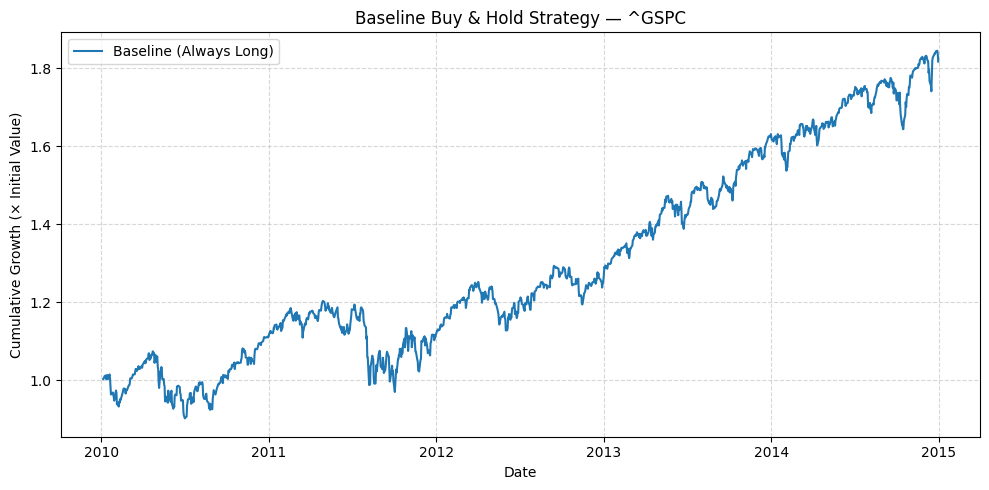

In [ ]:
# --- Plot cumulative equity curve ---
plt.figure(figsize=(10, 5))
plt.plot(equity_baseline, lw=1.5, label="Baseline (Always Long)")
plt.title(f"Baseline Buy & Hold Strategy — {SYMBOL}")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth (× Initial Value)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()



=== Performance Comparison ===
               Return     Vol  Sharpe     MDD
Baseline       0.0987  0.1344  0.7400 -0.1978
LPPL-Adaptive  0.0712  0.1218  0.5949 -0.1855


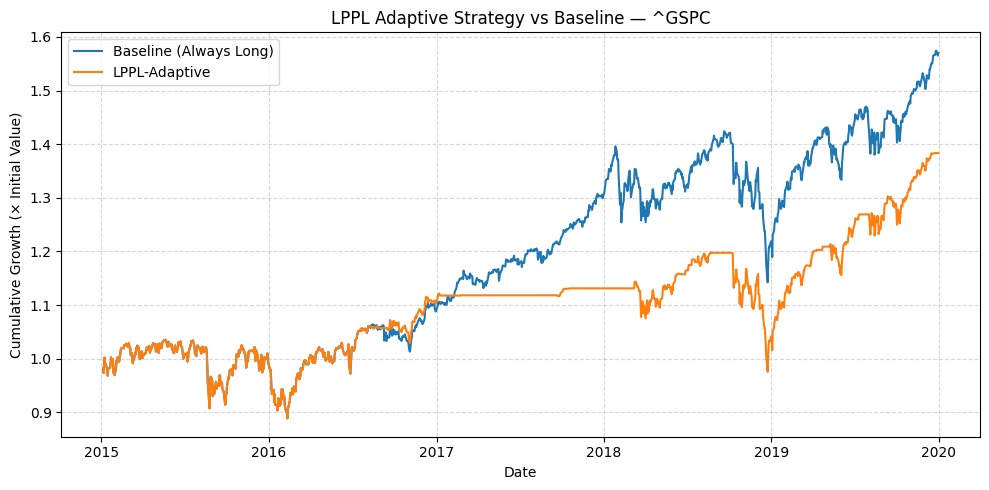

In [ ]:

# --- Performance metrics ---
def compute_metrics(rets, eq):
    annual_return = (eq.iloc[-1] / eq.iloc[0]) ** (252 / len(rets)) - 1
    annual_vol = rets.std() * np.sqrt(252)
    sharpe = (rets.mean() / rets.std()) * np.sqrt(252)
    max_dd = ((eq / eq.cummax()) - 1).min()
    return dict(Return=annual_return, Vol=annual_vol, Sharpe=sharpe, MDD=max_dd)

metrics = pd.DataFrame([
    compute_metrics(returns, equity_baseline),
    compute_metrics(strategy_returns, equity_lppl)
], index=["Baseline", "LPPL-Adaptive"])

print("\n=== Performance Comparison ===")
print(metrics.round(4))

# --- Plot comparison ---
plt.figure(figsize=(10, 5))
plt.plot(equity_baseline, label="Baseline (Always Long)", lw=1.5)
plt.plot(equity_lppl, label="LPPL-Adaptive", lw=1.5)
plt.title(f"LPPL Adaptive Strategy vs Baseline — {SYMBOL}")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth (× Initial Value)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
distributions_array[22][0]


,window_years,tc,A,B,C1,C2,m,omega,r2,rmse,kappa,sign,delta
0,0.576146,1.996018,7.767766,-0.203103,-0.017089,0.020547,0.900000,11.556697,0.908021,0.010447,0.203103,1,0.051288
1,0.603525,1.861166,7.746954,-0.219541,0.005293,0.042308,0.900000,8.583650,0.912632,0.012067,0.219541,1,0.083564
2,0.630903,1.947473,7.762297,-0.211849,-0.008312,0.031960,0.900000,10.585538,0.922272,0.012206,0.211849,1,0.002744
3,0.658282,1.929483,7.758752,-0.212348,-0.005014,0.033880,0.900000,10.163380,0.931201,0.012113,0.212348,1,0.015247
4,0.685661,2.044058,7.779081,-0.206431,-0.023382,0.016064,0.899999,12.999974,0.925928,0.012918,0.206431,1,0.099328


In [ ]:
len(distributions_array)

373

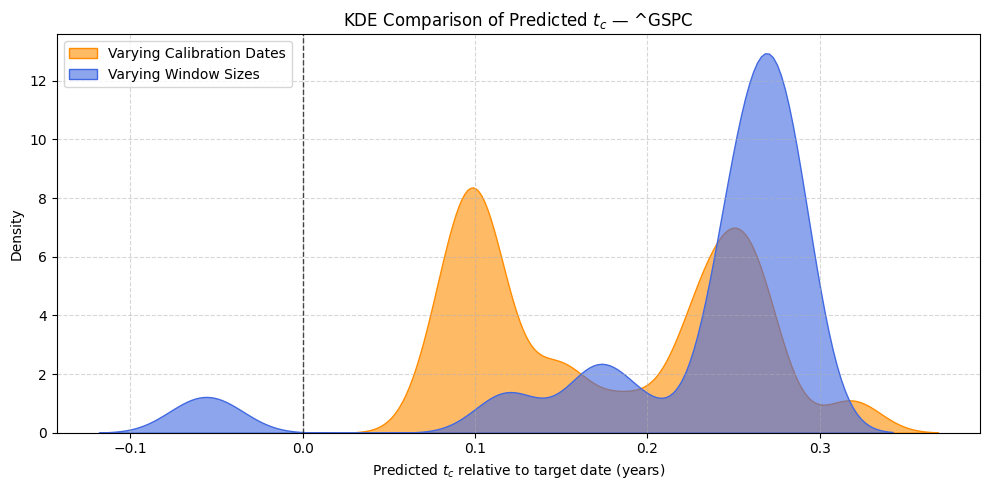

In [ ]:
i = 107
tc_w = distributions_array[i][0]["tc"] - (target_date_[i] - data.index[0]).days / 365.25
tc_d = distributions_array[i][1]["tc"] - (target_date_[i] - data.index[0]).days / 365.25
plot_combined_tc_distributions(tc_w, tc_d, symbol=SYMBOL)

In [ ]:
parameters_[i]


[3.0,
 np.float64(0.6456019491326314),
 np.float64(0.7226927271699778),
 np.float64(0.5767345665093717),
 np.float64(-0.9368058473978942)]

In [ ]:
# --- Convert dates to fractional years (for LPPL) ---
t_series = (data.index - data.index[0]).days / 365.25

# --- Instantiate calibrators ---
cal_window = DistributionLPPLCalibrator_for_different_Windows(t_series, p_series)
cal_window.set_model_params_initial_guess(tc_offset=0.12, m0=0.55, omega0=9.0)
cal_window.set_acceptance_thresholds(r2_min=0.9, rmse_max=0.06, kappa_min=0.05, tc_horizon_years=0.5)

cal_date = DistributionLPPLCalibrator_for_different_Dates(t_series, p_series)
cal_date.set_model_params_initial_guess(tc_offset=0.12, m0=0.55, omega0=9.0)
cal_date.set_acceptance_thresholds(r2_min=0.9, rmse_max=0.06, kappa_min=0.05, tc_horizon_years=0.5)

# --- Backtest setup ---
returns = (p_series[1:] - p_series[:-1]) / p_series[:-1]
returns = pd.Series(returns.flatten(), index=data.index[1:])

dates = returns.index
t_values = (dates - data.index[0]).days / 365.25

weights = []
parameters_ = []
alpha = 2.0   # defensive sensitivity
beta = 3.0    # aggressive sensitivity (leverage during rebound)

# --- Rolling simulation ---
for t_current, target_d in tqdm(zip(t_values, dates), desc="Running LPPL directional strategy"):
    # Skip if too early (not enough history)
    if t_current < 1.5:
        weights.append(1.0)
        continue

    # --- Across different window sizes ---
    dist_w = cal_window.tc_distribution_over_window(
        target_date=t_current,
        min_window_years=1/12,   # 1 month
        max_window_years=1.0,    # 1 year
        step_window_years=10/365.25,
        acceptance_thresholds=True
    )

    if dist_w.empty or "tc" not in dist_w.columns:
        weights.append(1.0)
        continue

    # Pick most "imminent" window (tc closest to t_current + 0.25y)
    dist_w["delta"] = np.abs(dist_w["tc"] - (t_current + 0.25))
    best_row = dist_w.loc[dist_w["delta"].idxmin()]
    best_window = best_row["window_years"]

    # --- Across different calibration dates ---
    dist_d = cal_date.tc_distribution_over_dates(
        target_date=t_current,
        window_years=best_window,
        distribution_window_years=1/12,
        step_years=1/365.25,
        acceptance_thresholds=True
    )

    # Skip invalid
    if dist_d.empty or len(dist_w) < 3 or len(dist_d) < 3:
        weights.append(1.0)
        continue

    # --- Compute directional bubble signal ---
    # Mean bubble sign across both calibrations
    sign_mean = np.mean(np.concatenate([dist_w["sign"].values, dist_d["sign"].values]))

    # Positive sign → green (upward bubble, usually pre-crash)
    # Negative sign → red (anti-bubble, recovery phase)

    # --- Compute crash proximity probabilities ---
    tc_w = dist_w["tc"].values
    tc_d = dist_d["tc"].values
    delta_w = tc_w - t_current
    delta_d = tc_d - t_current

    if len(delta_w) < 2 or len(delta_d) < 2:
        weights.append(1.0)
        continue

    kde_w = gaussian_kde(delta_w)
    kde_d = gaussian_kde(delta_d)
    crash_prob_w = kde_w.integrate_box_1d(0, 0.25)
    crash_prob_d = kde_d.integrate_box_1d(0, 0.25)
    crash_prob = np.sqrt(crash_prob_w * crash_prob_d)

    # --- Compute exposure based on bubble polarity ---
    if sign_mean > 0:
        # Red bubble → approaching instability → go defensive
        # Lower exposure as crash probability increases
        w = 1 - alpha * crash_prob

    else:
        # Green bubble (anti-bubble) → recovery phase
        # Increase exposure (even leverage slightly)
        w = 1 + beta * crash_prob

    # --- Stabilize and clip ---
    w = np.clip(w, 0.2, 2.5)  # never fully short, cap leverage to 2.5x
    weights.append(w)

    parameters_.append({
        "date": target_d,
        "sign": sign_mean,
        "crash_prob": crash_prob,
        "weight": w
    })

# --- Align and backtest ---
weights = pd.Series(weights, index=dates).reindex(returns.index, method="ffill")
strategy_returns = weights.shift(1).fillna(1.0) * returns
equity_lppl = (1 + strategy_returns).cumprod()

Running LPPL directional strategy: 1257it [07:36,  2.76it/s] 



=== Performance Comparison ===
               Return     Vol  Sharpe     MDD
Baseline       0.0987  0.1344  0.7400 -0.1978
LPPL-Adaptive  0.0769  0.1225  0.6362 -0.1877


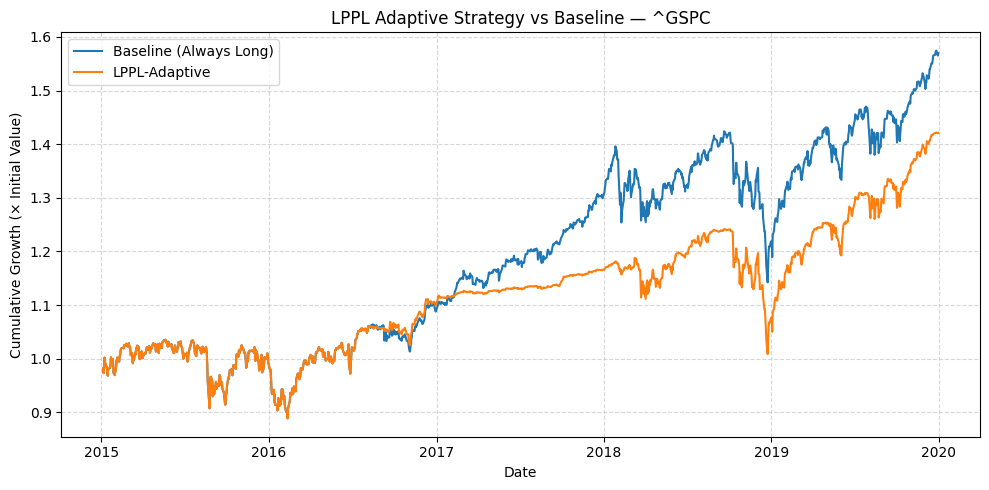

In [ ]:

# --- Performance metrics ---
def compute_metrics(rets, eq):
    annual_return = (eq.iloc[-1] / eq.iloc[0]) ** (252 / len(rets)) - 1
    annual_vol = rets.std() * np.sqrt(252)
    sharpe = (rets.mean() / rets.std()) * np.sqrt(252)
    max_dd = ((eq / eq.cummax()) - 1).min()
    return dict(Return=annual_return, Vol=annual_vol, Sharpe=sharpe, MDD=max_dd)

metrics = pd.DataFrame([
    compute_metrics(returns, equity_baseline),
    compute_metrics(strategy_returns, equity_lppl)
], index=["Baseline", "LPPL-Adaptive"])

print("\n=== Performance Comparison ===")
print(metrics.round(4))

# --- Plot comparison ---
plt.figure(figsize=(10, 5))
plt.plot(equity_baseline, label="Baseline (Always Long)", lw=1.5)
plt.plot(equity_lppl, label="LPPL-Adaptive", lw=1.5)
plt.title(f"LPPL Adaptive Strategy vs Baseline — {SYMBOL}")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth (× Initial Value)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()